In [1]:
from functools import partial
from pathlib import Path
from pprint import pprint
from time import sleep
from timeit import default_timer

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import seaborn as sns
from psycopg2.extras import RealDictCursor
from sqlalchemy import create_engine

In [3]:
from ingestion import (
    DBNAME,
    HOST,
    PASSWORD,
    PORT,
    USER,
    ingest_data_files,
    reset_db_structures,
)

In [4]:
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}")

## Reset DB Structures

In [5]:
input_csvs_small = [Path("/workspaces/data-playground/data/user_events.small.csv")]
input_csvs_large = [
    Path("/workspaces/data-playground/data/user_events.large.part01.csv"),
    Path("/workspaces/data-playground/data/user_events.large.part02.csv"),
]

In [6]:
reset_db_structures()
ingest_data_files(input_csvs_small)

Dropping db 'db_user_events'
Creating db 'db_user_events'
Creating table 't_user_events'
Copying data from /workspaces/data-playground/data/user_events.small.csv to table 't_user_events'
Count of 't_user_events': 885_129


## Utility Functions

In [7]:
pprint = partial(pprint, sort_dicts=False, underscore_numbers=True)

In [8]:
def execute_trans_query(query: str, *, fetch_size: int = 0) -> list[dict]:
    with (
        psycopg2.connect(
            host=HOST,
            port=PORT,
            user=USER,
            password=PASSWORD,
            database=DBNAME,
            cursor_factory=RealDictCursor,
        ) as conn,
        conn.cursor() as cur,
    ):
        cur.execute(query)
        match fetch_size:
            case 0:
                return None
            case 1:
                return dict(cur.fetchone())
        return [dict(res) for res in cur.fetchmany(fetch_size)]

In [9]:
def execute_non_trans_query(query: str, *, fetch_size: int = 0) -> list[dict]:
    conn = psycopg2.connect(host=HOST, user=USER, password=PASSWORD, dbname=DBNAME)
    conn.autocommit = True
    cur = conn.cursor()
    try:
        cur.execute(query)
        match fetch_size:
            case 0:
                return None
            case 1:
                return dict(cur.fetchone())
        return [dict(res) for res in cur.fetchmany(fetch_size)]
    except Exception:
        cur.close()
        conn.close()
        raise
    finally:
        cur.close()
        conn.close()

In [10]:
def print_count(table_name="t_user_events"):
    query = f"SELECT count(1) FROM {table_name}"
    res = execute_trans_query(query, fetch_size=1)
    print(f"Count: {res['count']:_}")

In [11]:
def print_current_hypertables():
    query = """
        SELECT hypertable_name, num_dimensions, num_chunks, compression_enabled
        FROM timescaledb_information.hypertables;"""
    res = execute_trans_query(query, fetch_size=3)
    print("Current hypertables:")
    pprint(res)

In [12]:
def print_chunk_info(table_name="t_user_events", order_by_stmt="", fetch_size=3):
    query = f"""
        SELECT chunk_name, is_compressed, range_start, range_end
        FROM timescaledb_information.chunks
        WHERE hypertable_name = '{table_name}'
        {order_by_stmt};"""
    res = execute_trans_query(query, fetch_size=fetch_size)
    print("Current chunks info:")
    pprint(res)

In [13]:
def print_compression_settings(fetch_size=10):
    query = """
        SELECT *
        FROM timescaledb_information.compression_settings
        WHERE hypertable_name = 't_user_events';"""
    res = execute_trans_query(query, fetch_size=fetch_size)
    print("Compression settings:")
    pprint(res)

## Query Statements

In [14]:
query = """
    SELECT extversion
    FROM pg_extension
    WHERE extname = 'timescaledb';"""
version = execute_trans_query(query, fetch_size=1)["extversion"]
print(f"TimescaleDB version: {version}")

TimescaleDB version: 2.18.0


In [15]:
print_current_hypertables()

Current hypertables:
[]


In [16]:
print_chunk_info()

Current chunks info:
[]


In [17]:
query = """
    SELECT create_hypertable(
                't_user_events',
                'event_time',
                chunk_time_interval => INTERVAL '1 day',
                migrate_data => TRUE,
                if_not_exists => TRUE);"""
res = execute_trans_query(query, fetch_size=0)

In [18]:
print_current_hypertables()

Current hypertables:
[{'hypertable_name': 't_user_events',
  'num_dimensions': 1,
  'num_chunks': 158,
  'compression_enabled': False}]


In [19]:
print_chunk_info()

Current chunks info:
[{'chunk_name': '_hyper_1_1_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2020, 9, 24, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 9, 25, 0, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_2_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2020, 9, 29, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 9, 30, 0, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_3_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2020, 10, 2, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 10, 3, 0, 0, tzinfo=datetime.timezone.utc)}]


In [20]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789
        AND event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Result  (cost=0.00..0.00 rows=0 width=0)
  One-Time Filter: false


In [21]:
query = """
    CREATE MATERIALIZED VIEW mvw_event_counts
    WITH (timescaledb.continuous) AS
    SELECT
        time_bucket('1 hour', event_time) AS bucket,
        event_type,
        COUNT(*) AS event_count
    FROM t_user_events
    GROUP BY bucket, event_type;"""
res = execute_non_trans_query(query, fetch_size=0)

In [22]:
query = """
    SELECT add_continuous_aggregate_policy(
                'mvw_event_counts',
                start_offset => INTERVAL '100 years',
                end_offset => INTERVAL '1 hour',
                schedule_interval => INTERVAL '1 day');"""
res = execute_trans_query(query, fetch_size=0)

In [23]:
query = """
    SELECT *
    FROM mvw_event_counts
    ORDER BY bucket ASC;"""
res = execute_trans_query(query, fetch_size=6)
pprint(res)

[{'bucket': datetime.datetime(2020, 9, 24, 11, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'event_count': 13},
 {'bucket': datetime.datetime(2020, 9, 24, 12, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'purchase',
  'event_count': 18},
 {'bucket': datetime.datetime(2020, 9, 24, 12, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'event_count': 238},
 {'bucket': datetime.datetime(2020, 9, 24, 12, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'cart',
  'event_count': 14},
 {'bucket': datetime.datetime(2020, 9, 24, 13, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'purchase',
  'event_count': 10},
 {'bucket': datetime.datetime(2020, 9, 24, 13, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'event_count': 255}]


In [24]:
query = """
    EXPLAIN
    SELECT *
    FROM mvw_event_counts
    ORDER BY bucket ASC;"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Custom Scan (ChunkAppend) on _materialized_hypertable_2  (cost=0.15..357.33 rows=5270 width=234)
  Order: _materialized_hypertable_2.bucket
  ->  Index Scan Backward using _hyper_2_175_chunk__materialized_hypertable_2_bucket_idx on _hyper_2_175_chunk  (cost=0.15..18.00 rows=310 width=234)
  ->  Index Scan Backward using _hyper_2_170_chunk__materialized_hypertable_2_bucket_idx on _hyper_2_170_chunk  (cost=0.27..21.42 rows=310 width=234)
  ->  Index Scan Backward using _hyper_2_161_chunk__materialized_hypertable_2_bucket_idx on _hyper_2_161_chunk  (cost=0.27..21.42 rows=310 width=234)
  ->  Index Scan Backward using _hyper_2_167_chunk__materialized_hypertable_2_bucket_idx on _hyper_2_167_chunk  (cost=0.27..21.42 rows=310 width=234)
  ->  Index Scan Backward using _hyper_2_171_chunk__materialized_hypertable_2_bucket_idx on _hyper_2_171_chunk  (cost=0.27..21.42 rows=310 width=234)
  ->  Index Scan Backward using _hyper_2_169_chunk__materialized_hypertable_2_bucket_idx on _hyper_2_169_chunk

In [25]:
query = """
    EXPLAIN
    SELECT *
    FROM mvw_event_counts
    WHERE bucket >= '2020-09-24 11:00:00'
        AND bucket < '2020-09-24 12:00:00';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Bitmap Heap Scan on _hyper_2_175_chunk  (cost=1.27..3.41 rows=2 width=234)
  Recheck Cond: ((bucket >= '2020-09-24 11:00:00+00'::timestamp with time zone) AND (bucket < '2020-09-24 12:00:00+00'::timestamp with time zone))
  ->  Bitmap Index Scan on _hyper_2_175_chunk__materialized_hypertable_2_bucket_idx  (cost=0.00..1.27 rows=2 width=0)
        Index Cond: ((bucket >= '2020-09-24 11:00:00+00'::timestamp with time zone) AND (bucket < '2020-09-24 12:00:00+00'::timestamp with time zone))


In [26]:
query = """
    SELECT set_chunk_time_interval('t_user_events', INTERVAL '1 hour');"""
res = execute_non_trans_query(query, fetch_size=0)
# NOTE: the new chunk interval applies only to future chunks

In [27]:
print_chunk_info(fetch_size=3)

Current chunks info:
[{'chunk_name': '_hyper_1_1_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2020, 9, 24, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 9, 25, 0, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_2_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2020, 9, 29, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 9, 30, 0, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_3_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2020, 10, 2, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 10, 3, 0, 0, tzinfo=datetime.timezone.utc)}]


In [28]:
query = """
    INSERT INTO t_user_events
    SELECT
        event_time - (INTERVAL '10 years'),
        event_type,
        product_id,
        category_id,
        category_code,
        brand,
        price,
        user_id,
        user_session
    FROM t_user_events;"""
res = execute_trans_query(query, fetch_size=0)

In [29]:
print_chunk_info(
    table_name="t_user_events",
    order_by_stmt="ORDER BY range_end ASC",
    fetch_size=3,
)

Current chunks info:
[{'chunk_name': '_hyper_1_176_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2010, 9, 24, 11, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2010, 9, 24, 12, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_177_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2010, 9, 24, 12, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2010, 9, 24, 13, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_178_chunk',
  'is_compressed': False,
  'range_start': datetime.datetime(2010, 9, 24, 13, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2010, 9, 24, 14, 0, tzinfo=datetime.timezone.utc)}]


In [30]:
query = """
    SELECT
        event_time,
        event_type,
        category_code,
        user_id
    FROM t_user_events
    WHERE user_id = 1515915625519380411
    AND event_time > '2015-01-01';"""
res = execute_trans_query(query, fetch_size=3)
pprint(res)

[{'event_time': datetime.datetime(2020, 9, 24, 11, 57, 26, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'category_code': 'computers.components.cooler',
  'user_id': 1_515_915_625_519_380_411},
 {'event_time': datetime.datetime(2020, 9, 24, 12, 15, 11, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'category_code': 'computers.components.power_supply',
  'user_id': 1_515_915_625_519_380_411},
 {'event_time': datetime.datetime(2020, 9, 24, 12, 19, 57, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'category_code': 'computers.components.cooler',
  'user_id': 1_515_915_625_519_380_411}]


In [31]:
query = """
    SELECT
        brand,
        avg(price) AS avg_price
    FROM t_user_events
    WHERE event_time > '2015-01-01'
    GROUP BY brand;"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'brand': 'pro', 'avg_price': Decimal('33.1026666666666667')},
 {'brand': 'goip', 'avg_price': Decimal('220.6800000000000000')},
 {'brand': 'knipex', 'avg_price': Decimal('54.2400000000000000')},
 {'brand': 'zmi', 'avg_price': Decimal('61.2700000000000000')},
 {'brand': 'hyperx', 'avg_price': Decimal('90.0882915863840719')}]


In [32]:
query = """
    SELECT
        user_id,
        count(*) AS event_count
    FROM t_user_events
    WHERE event_time > '2015-01-01'
    GROUP BY user_id
    ORDER BY count(*) DESC;"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'user_id': 1_515_915_625_554_995_474, 'event_count': 572},
 {'user_id': 1_515_915_625_527_763_086, 'event_count': 424},
 {'user_id': 1_515_915_625_591_251_010, 'event_count': 363},
 {'user_id': 1_515_915_625_591_659_523, 'event_count': 339},
 {'user_id': 1_515_915_625_537_803_839, 'event_count': 329}]


In [33]:
query = """
    SELECT DISTINCT event_type
    FROM t_user_events
    WHERE user_id = 1515915625554995474
        AND event_time > '2015-01-01';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'event_type': 'view'}]


In [34]:
query = """
    UPDATE t_user_events
    SET event_type = 'hover'
    WHERE user_id = 1515915625554995474
        AND event_time > '2015-01-01';"""
res = execute_trans_query(query, fetch_size=0)

In [35]:
query = """
    SELECT DISTINCT event_type
    FROM t_user_events
    WHERE user_id = 1515915625554995474
        AND event_time > '2015-01-01';"""
res = execute_trans_query(query, fetch_size=1)
pprint(res)

{'event_type': 'hover'}


In [36]:
query = """
    SELECT count(*)
    FROM t_user_events
    WHERE event_time < '2015-01-01';"""
res = execute_trans_query(query, fetch_size=1)
pprint(res)

{'count': 885_129}


In [37]:
query = """
    DELETE FROM t_user_events
    WHERE event_time < '2015-01-01';"""
res = execute_trans_query(query, fetch_size=0)
pprint(res)

None


In [38]:
query = """
    SELECT count(*)
    FROM t_user_events
    WHERE event_time < '2015-01-01';"""
res = execute_trans_query(query, fetch_size=1)
pprint(res)

{'count': 0}


In [39]:
query = """
    SELECT event_time, user_session
    FROM t_user_events
    WHERE event_type = 'purchase'
        AND event_time > '2020-12-08'
        AND event_time < '2020-12-08 05:00:00 UTC';"""
res = execute_trans_query(query, fetch_size=3)
pprint(res)

[{'event_time': datetime.datetime(2020, 12, 8, 4, 38, 3, tzinfo=datetime.timezone.utc),
  'user_session': 'L6ew7YkyVP'},
 {'event_time': datetime.datetime(2020, 12, 8, 4, 37, 46, tzinfo=datetime.timezone.utc),
  'user_session': 'p9iO5LmqMB'},
 {'event_time': datetime.datetime(2020, 12, 8, 4, 34, 51, tzinfo=datetime.timezone.utc),
  'user_session': 'XUxkExWX01'}]


In [40]:
query = """
    INSERT INTO t_user_events (
        event_time, event_type, product_id,
        category_id, category_code, brand,
        price, user_id, user_session)
    VALUES
        ('2024-02-01 12:34:56', 'purchase', 123,
            456, 'electronics.smartphone', 'BrandX',
            599.99, 789, 'a0eebc99-9c0b-4ef8-bb6d-6bb9bd380a11'),
        ('2024-02-01 13:45:12', 'view', 124,
            457, 'electronics.tablet', 'BrandY',
            299.99, 790, 'b1eebc99-9c0b-4ef8-bb6d-6bb9bd380a12'),
        ('2024-02-01 14:56:23', 'cart', 125,
            458, 'electronics.laptop', 'BrandZ',
            999.99, 791, 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13');"""
res = execute_trans_query(query, fetch_size=0)

In [41]:
query = """
    SELECT *
    FROM t_user_events
    WHERE event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=3)
pprint(res)

[{'event_time': datetime.datetime(2024, 2, 1, 12, 34, 56, tzinfo=datetime.timezone.utc),
  'event_type': 'purchase',
  'product_id': 123,
  'category_id': 456,
  'category_code': 'electronics.smartphone',
  'brand': 'BrandX',
  'price': Decimal('599.99'),
  'user_id': 789,
  'user_session': 'a0eebc99-9c0b-4ef8-bb6d-6bb9bd380a11'},
 {'event_time': datetime.datetime(2024, 2, 1, 13, 45, 12, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'product_id': 124,
  'category_id': 457,
  'category_code': 'electronics.tablet',
  'brand': 'BrandY',
  'price': Decimal('299.99'),
  'user_id': 790,
  'user_session': 'b1eebc99-9c0b-4ef8-bb6d-6bb9bd380a12'},
 {'event_time': datetime.datetime(2024, 2, 1, 14, 56, 23, tzinfo=datetime.timezone.utc),
  'event_type': 'cart',
  'product_id': 125,
  'category_id': 458,
  'category_code': 'electronics.laptop',
  'brand': 'BrandZ',
  'price': Decimal('999.99'),
  'user_id': 791,
  'user_session': 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'}]


In [42]:
query = """
    UPDATE t_user_events
    SET price = '00.99'
    WHERE product_id = 124;"""
res = execute_trans_query(query, fetch_size=0)

In [43]:
query = """
    CREATE INDEX ix_events_user_id ON t_user_events (user_id);"""
res = execute_trans_query(query, fetch_size=0)

In [44]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789;"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.28..11201.85 rows=5957 width=912)
  ->  Index Scan using _hyper_1_1_chunk_ix_events_user_id on _hyper_1_1_chunk  (cost=0.28..2.50 rows=1 width=72)
        Index Cond: (user_id = 789)
  ->  Bitmap Heap Scan on _hyper_1_2_chunk  (cost=1.58..24.99 rows=25 width=932)
        Recheck Cond: (user_id = 789)
        ->  Bitmap Index Scan on _hyper_1_2_chunk_ix_events_user_id  (cost=0.00..1.57 rows=25 width=0)
              Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_3_chunk_ix_events_user_id on _hyper_1_3_chunk  (cost=0.28..2.50 rows=1 width=73)
        Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_4_chunk_ix_events_user_id on _hyper_1_4_chunk  (cost=0.28..2.50 rows=1 width=72)


In [45]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789
        AND event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.07 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))


In [46]:
query = """
    CREATE INDEX ix_events_time_user_id ON t_user_events (event_time DESC, user_id);"""
res = execute_trans_query(query, fetch_size=0)

In [47]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789;"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.28..11201.85 rows=5957 width=912)
  ->  Index Scan using _hyper_1_1_chunk_ix_events_user_id on _hyper_1_1_chunk  (cost=0.28..2.50 rows=1 width=72)
        Index Cond: (user_id = 789)
  ->  Bitmap Heap Scan on _hyper_1_2_chunk  (cost=1.58..24.99 rows=25 width=932)
        Recheck Cond: (user_id = 789)
        ->  Bitmap Index Scan on _hyper_1_2_chunk_ix_events_user_id  (cost=0.00..1.57 rows=25 width=0)
              Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_3_chunk_ix_events_user_id on _hyper_1_3_chunk  (cost=0.28..2.50 rows=1 width=73)
        Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_4_chunk_ix_events_user_id on _hyper_1_4_chunk  (cost=0.28..2.50 rows=1 width=72)


In [48]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789
        AND event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.07 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))


In [49]:
sleep(60)
query = """
    DROP INDEX IF EXISTS ix_events_user_id;"""
res = execute_trans_query(query, fetch_size=0)

In [50]:
query = """
    CREATE INDEX idx_event_time_type ON t_user_events(event_time DESC, event_type)
        WITH (timescaledb.transaction_per_chunk);"""
res = execute_non_trans_query(query, fetch_size=0)

In [51]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789;"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.28..11263.40 rows=4064 width=872)
  ->  Index Scan using _hyper_1_1_chunk_ix_events_time_user_id on _hyper_1_1_chunk  (cost=0.28..30.48 rows=1 width=72)
        Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_2_chunk_ix_events_time_user_id on _hyper_1_2_chunk  (cost=0.28..62.96 rows=1 width=74)
        Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_3_chunk_ix_events_time_user_id on _hyper_1_3_chunk  (cost=0.28..57.55 rows=1 width=73)
        Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_4_chunk_ix_events_time_user_id on _hyper_1_4_chunk  (cost=0.28..54.10 rows=1 width=72)
        Index Cond: (user_id = 789)
  ->  Index Scan using _hyper_1_5_chunk_ix_events_time_user_id on _hyper_1_5_chunk  (cost=0.28..48.40 rows=1 width=72)


In [52]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_id = 789
        AND event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.07 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND (user_id = 789))


In [53]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_session = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Gather  (cost=1000.00..21308.78 rows=3978 width=891)
  Workers Planned: 6
  ->  Parallel Append  (cost=0.00..19910.98 rows=1 width=890)
        ->  Seq Scan on _hyper_1_240_chunk  (cost=0.00..1.00 rows=1 width=932)
              Filter: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
        ->  Seq Scan on _hyper_1_260_chunk  (cost=0.00..1.00 rows=1 width=932)
              Filter: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
        ->  Seq Scan on _hyper_1_264_chunk  (cost=0.00..1.00 rows=1 width=932)
              Filter: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
        ->  Seq Scan on _hyper_1_286_chunk  (cost=0.00..1.00 rows=1 width=932)


In [54]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_session = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'
        AND event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.07 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text))


In [55]:
query = """
    CREATE INDEX idx_event_session ON t_user_events USING HASH(user_session);"""
res = execute_trans_query(query, fetch_size=0)

In [56]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_session = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..570.58 rows=3978 width=890)
  ->  Index Scan using _hyper_1_1_chunk_idx_event_session on _hyper_1_1_chunk  (cost=0.00..2.22 rows=1 width=72)
        Index Cond: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
  ->  Index Scan using _hyper_1_2_chunk_idx_event_session on _hyper_1_2_chunk  (cost=0.00..2.22 rows=1 width=74)
        Index Cond: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
  ->  Index Scan using _hyper_1_3_chunk_idx_event_session on _hyper_1_3_chunk  (cost=0.00..2.22 rows=1 width=73)
        Index Cond: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
  ->  Index Scan using _hyper_1_4_chunk_idx_event_session on _hyper_1_4_chunk  (cost=0.00..2.22 rows=1 width=72)
        Index Cond: ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text)
  ->  Index Scan using _hyper_1_5_chunk_idx_event_session on _hyper_1_5_chunk  (cost=0.00..2.22 rows=1 width=72)


In [57]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE user_session = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'
        AND event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.07 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.02 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone) AND ((user_session)::text = 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13'::text))


In [58]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.06 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.01 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.01 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.01 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone))


In [59]:
query = """
    CREATE INDEX idx_event_time ON t_user_events (event_time);"""
res = execute_trans_query(query, fetch_size=0)

In [60]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE event_time > '2024-02-01'
        AND event_time < '2024-02-02';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Append  (cost=0.00..3.06 rows=3 width=932)
  ->  Seq Scan on _hyper_1_3955_chunk  (cost=0.00..1.01 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone))
  ->  Seq Scan on _hyper_1_3956_chunk  (cost=0.00..1.01 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone))
  ->  Seq Scan on _hyper_1_3957_chunk  (cost=0.00..1.01 rows=1 width=932)
        Filter: ((event_time > '2024-02-01 00:00:00+00'::timestamp with time zone) AND (event_time < '2024-02-02 00:00:00+00'::timestamp with time zone))


In [61]:
query = """
    SELECT show_chunks('t_user_events');"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'show_chunks': '_timescaledb_internal._hyper_1_1_chunk'},
 {'show_chunks': '_timescaledb_internal._hyper_1_2_chunk'},
 {'show_chunks': '_timescaledb_internal._hyper_1_3_chunk'},
 {'show_chunks': '_timescaledb_internal._hyper_1_4_chunk'},
 {'show_chunks': '_timescaledb_internal._hyper_1_5_chunk'}]


In [62]:
query = """
    SELECT *
    FROM timescaledb_information.dimensions
    WHERE hypertable_name = 't_user_events';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'dimension_number': 1,
  'column_name': 'event_time',
  'column_type': 'timestamp with time zone',
  'dimension_type': 'Time',
  'time_interval': datetime.timedelta(seconds=3600),
  'integer_interval': None,
  'integer_now_func': None,
  'num_partitions': None}]


In [63]:
query = """
    SELECT COUNT(DISTINCT category_code) FROM t_user_events"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'count': 110}]


In [64]:
query = """
    EXPLAIN
    SELECT *
    FROM t_user_events
    WHERE category_code = 'computers.peripherals.wifi';"""
res = execute_trans_query(query, fetch_size=10)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Gather  (cost=1000.00..22004.91 rows=10880 width=372)
  Workers Planned: 6
  ->  Parallel Append  (cost=0.00..19916.91 rows=1185 width=372)
        ->  Seq Scan on _hyper_1_240_chunk  (cost=0.00..1.00 rows=1 width=932)
              Filter: ((category_code)::text = 'computers.peripherals.wifi'::text)
        ->  Seq Scan on _hyper_1_260_chunk  (cost=0.00..1.00 rows=1 width=932)
              Filter: ((category_code)::text = 'computers.peripherals.wifi'::text)
        ->  Seq Scan on _hyper_1_264_chunk  (cost=0.00..1.00 rows=1 width=932)
              Filter: ((category_code)::text = 'computers.peripherals.wifi'::text)
        ->  Seq Scan on _hyper_1_286_chunk  (cost=0.00..1.00 rows=1 width=932)


In [65]:
query = """
    EXPLAIN
    SELECT time_bucket('1 hour', event_time) AS bucket,
        category_code,
        AVG(price) AS avg_price
    FROM t_user_events
    WHERE event_time < '2015-01-01'
    GROUP BY bucket, category_code;"""
res = execute_trans_query(query, fetch_size=20)
print(*[v for dct in res for _, v in dct.items()], sep="\n")

Finalize HashAggregate  (cost=412523.49..412578.03 rows=3636 width=258)
  Group Key: (time_bucket('01:00:00'::interval, _hyper_1_176_chunk.event_time)), _hyper_1_176_chunk.category_code
  ->  Append  (cost=11.27..275119.05 rows=13740444 width=258)
        ->  Partial HashAggregate  (cost=11.27..65.81 rows=3636 width=258)
              Group Key: time_bucket('01:00:00'::interval, _hyper_1_176_chunk.event_time), _hyper_1_176_chunk.category_code
              ->  Seq Scan on _hyper_1_176_chunk  (cost=0.00..11.07 rows=27 width=258)
                    Filter: (event_time < '2015-01-01 00:00:00+00'::timestamp with time zone)
        ->  Partial HashAggregate  (cost=0.01..54.55 rows=3636 width=258)
              Group Key: time_bucket('01:00:00'::interval, _hyper_1_177_chunk.event_time), _hyper_1_177_chunk.category_code
              ->  Seq Scan on _hyper_1_177_chunk  (cost=0.00..0.00 rows=1 width=258)
                    Filter: (event_time < '2015-01-01 00:00:00+00'::timestamp with time z

In [66]:
query = """
    SELECT add_dimension(
                't_user_events',
                by_hash('category_code', 110));"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'add_dimension': '(3,t)'}]


In [67]:
query = """
    SELECT *
    FROM timescaledb_information.dimensions
    WHERE hypertable_name = 't_user_events';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'dimension_number': 1,
  'column_name': 'event_time',
  'column_type': 'timestamp with time zone',
  'dimension_type': 'Time',
  'time_interval': datetime.timedelta(seconds=3600),
  'integer_interval': None,
  'integer_now_func': None,
  'num_partitions': None},
 {'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'dimension_number': 2,
  'column_name': 'category_code',
  'column_type': 'character varying',
  'dimension_type': 'Space',
  'time_interval': None,
  'integer_interval': None,
  'integer_now_func': None,
  'num_partitions': 110}]


In [68]:
query = """
    SELECT *
    FROM mvw_event_counts
    WHERE bucket > '2024-01-01'
    ORDER BY bucket ASC;"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[]


In [69]:
query = """
    CALL refresh_continuous_aggregate(
        'mvw_event_counts',
        '2024-01-01',
        '2024-03-31');"""
res = execute_non_trans_query(query, fetch_size=0)

In [70]:
sleep(60)
query = """
    SELECT *
    FROM mvw_event_counts
    WHERE bucket > '2024-01-01'
    ORDER BY bucket ASC;"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'bucket': datetime.datetime(2024, 2, 1, 12, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'purchase',
  'event_count': 1},
 {'bucket': datetime.datetime(2024, 2, 1, 13, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'view',
  'event_count': 1},
 {'bucket': datetime.datetime(2024, 2, 1, 14, 0, tzinfo=datetime.timezone.utc),
  'event_type': 'cart',
  'event_count': 1}]


In [71]:
query = """
    WITH cte AS (
        SELECT
            time_bucket('1 day', event_time) AS day_bucket,
            count(*) AS rolling_daily_count
        FROM t_user_events
        GROUP BY day_bucket)
    SELECT
        time_bucket('7 days', day_bucket) AS week_bucket,
        avg(rolling_daily_count) AS rolling_weekly_avg
    FROM cte
    GROUP BY week_bucket"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'week_bucket': datetime.datetime(2020, 9, 21, 0, 0, tzinfo=datetime.timezone.utc),
  'rolling_weekly_avg': Decimal('3455.5000000000000000')},
 {'week_bucket': datetime.datetime(2020, 9, 28, 0, 0, tzinfo=datetime.timezone.utc),
  'rolling_weekly_avg': Decimal('4521.5714285714285714')},
 {'week_bucket': datetime.datetime(2020, 10, 5, 0, 0, tzinfo=datetime.timezone.utc),
  'rolling_weekly_avg': Decimal('4401.4285714285714286')},
 {'week_bucket': datetime.datetime(2020, 10, 12, 0, 0, tzinfo=datetime.timezone.utc),
  'rolling_weekly_avg': Decimal('5093.5714285714285714')},
 {'week_bucket': datetime.datetime(2020, 10, 19, 0, 0, tzinfo=datetime.timezone.utc),
  'rolling_weekly_avg': Decimal('5898.0000000000000000')}]


In [72]:
query = """
    DROP MATERIALIZED VIEW IF EXISTS mvw_event_stats;"""
res = execute_non_trans_query(query, fetch_size=0)

In [73]:
query = """
    CREATE MATERIALIZED VIEW mvw_event_stats
    WITH (timescaledb.continuous) AS
    SELECT
        time_bucket('1 month', event_time) AS month_bucket,
        category_code,
        event_type,
        COUNT(*) AS event_count,
        AVG(price) AS price_avg
    FROM t_user_events
    WHERE category_code IS NOT NULL AND category_code <> ''
    GROUP BY month_bucket, category_code, event_type;"""
res = execute_non_trans_query(query, fetch_size=0)

In [74]:
query = """
    SELECT *
    FROM mvw_event_stats"""
res = execute_trans_query(query, fetch_size=3)
pprint(res)

[{'month_bucket': datetime.datetime(2020, 12, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'category_code': 'computers.components.motherboard',
  'event_type': 'view',
  'event_count': 4_003,
  'price_avg': Decimal('90.1486285286035473')},
 {'month_bucket': datetime.datetime(2020, 12, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'category_code': 'computers.components.cdrw',
  'event_type': 'cart',
  'event_count': 7,
  'price_avg': Decimal('80.8014285714285714')},
 {'month_bucket': datetime.datetime(2020, 12, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'category_code': 'construction.tools.heater',
  'event_type': 'purchase',
  'event_count': 2,
  'price_avg': Decimal('74.4400000000000000')}]


In [75]:
query = """
    SELECT
        time_bucket('15 minutes', event_time) AS fifteen_min_bucket,
        COUNT(DISTINCT product_id),
        AVG(price) AS price_avg
    FROM t_user_events
    GROUP BY fifteen_min_bucket, category_code, event_type"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'fifteen_min_bucket': datetime.datetime(2020, 9, 24, 11, 45, tzinfo=datetime.timezone.utc),
  'count': 5,
  'price_avg': Decimal('23.5150000000000000')},
 {'fifteen_min_bucket': datetime.datetime(2020, 9, 24, 11, 45, tzinfo=datetime.timezone.utc),
  'count': 1,
  'price_avg': Decimal('17.1600000000000000')},
 {'fifteen_min_bucket': datetime.datetime(2020, 9, 24, 11, 45, tzinfo=datetime.timezone.utc),
  'count': 1,
  'price_avg': Decimal('215.4100000000000000')},
 {'fifteen_min_bucket': datetime.datetime(2020, 9, 24, 11, 45, tzinfo=datetime.timezone.utc),
  'count': 1,
  'price_avg': Decimal('53.1400000000000000')},
 {'fifteen_min_bucket': datetime.datetime(2020, 9, 24, 11, 45, tzinfo=datetime.timezone.utc),
  'count': 1,
  'price_avg': Decimal('113.8100000000000000')}]


In [76]:
query = """
    CREATE TABLE t_product (
        product_id INT,
        product_name VARCHAR(100)
    );"""
res = execute_trans_query(query, fetch_size=0)

In [77]:
query = """
    INSERT INTO t_product (product_id, product_name)
    VALUES
        (123, 'Waldo'),
        (124, 'Sherry');"""
res = execute_trans_query(query, fetch_size=0)

In [78]:
query = """
    SELECT
        time_bucket('1 day', e.event_time) AS day_bucket,
        e.product_id,
        p.product_name,
        e.event_type,
        COUNT(*) event_count
    FROM t_user_events e
    INNER JOIN t_product p ON p.product_id = e.product_id
    GROUP BY day_bucket, e.product_id, p.product_name, e.event_type"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'day_bucket': datetime.datetime(2024, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'product_id': 123,
  'product_name': 'Waldo',
  'event_type': 'purchase',
  'event_count': 1},
 {'day_bucket': datetime.datetime(2024, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'product_id': 124,
  'product_name': 'Sherry',
  'event_type': 'view',
  'event_count': 1}]


In [79]:
query = """
    DROP FUNCTION IF EXISTS calculate_day_revenue;
    CREATE FUNCTION
        calculate_day_revenue(
        start_time TIMESTAMPTZ DEFAULT NULL,
        end_time TIMESTAMPTZ DEFAULT NULL)
    RETURNS
        TABLE (
            day_ts TIMESTAMPTZ,
            revenue NUMERIC) AS $$
    BEGIN
        RETURN QUERY
            SELECT
                time_bucket('1 day', event_time) AS day_bucket,
                sum(price) revenue
            FROM t_user_events
            WHERE event_type = 'purchase'
                AND (event_time >= start_time OR start_time IS NULL)
                AND (event_time < end_time OR end_time IS NULL)
            GROUP BY day_bucket;
    END;
    $$ LANGUAGE plpgsql;"""
res = execute_trans_query(query, fetch_size=0)

In [80]:
query = """
    SELECT calculate_day_revenue()"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'calculate_day_revenue': '("2020-09-24 00:00:00+00",9563.67)'},
 {'calculate_day_revenue': '("2020-09-25 00:00:00+00",13025.72)'},
 {'calculate_day_revenue': '("2020-09-26 00:00:00+00",11821.97)'},
 {'calculate_day_revenue': '("2020-09-27 00:00:00+00",7910.53)'},
 {'calculate_day_revenue': '("2020-09-28 00:00:00+00",15120.82)'}]


In [81]:
query = """
    SELECT event_time, price
    FROM t_user_events
    WHERE event_type = 'purchase'
        AND event_time >= '2024-01-01'"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'event_time': datetime.datetime(2024, 2, 1, 12, 34, 56, tzinfo=datetime.timezone.utc),
  'price': Decimal('599.99')}]


In [82]:
query = """
    SELECT calculate_day_revenue('2024-01-01')"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'calculate_day_revenue': '("2024-02-01 00:00:00+00",599.99)'}]


In [83]:
query = """
    INSERT INTO t_user_events (
        event_time, event_type, product_id,
        category_id, category_code, brand,
        price, user_id, user_session)
    VALUES
        ('2018-02-01 12:34:56', 'purchase', 123,
            456, 'electronics.smartphone', 'BrandX',
            599.99, 789, 'a0eebc99-9c0b-4ef8-bb6d-6bb9bd380a11'),
        ('2018-02-01 13:45:12', 'view', 124,
            457, 'electronics.tablet', 'BrandY',
            299.99, 790, 'b1eebc99-9c0b-4ef8-bb6d-6bb9bd380a12'),
        ('2018-02-01 14:56:23', 'cart', 125,
            458, 'electronics.laptop', 'BrandZ',
            999.99, 791, 'c2eebc99-9c0b-4ef8-bb6d-6bb9bd380a13');"""
res = execute_trans_query(query, fetch_size=0)

In [84]:
query = """
    SELECT
        time_bucket('1 year', event_time) AS year_bucket,
        count(*)
    FROM t_user_events
    WHERE event_time >= '2018-01-01' AND event_time < NOW()
    GROUP BY year_bucket"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'year_bucket': datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 3},
 {'year_bucket': datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 530_563},
 {'year_bucket': datetime.datetime(2021, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 354_566},
 {'year_bucket': datetime.datetime(2024, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 3}]


In [85]:
query = """
    SELECT
        time_bucket_gapfill('1 year', event_time) AS year_bucket,
        count(*)
    FROM t_user_events
    WHERE event_time >= '2018-01-01' AND event_time < NOW()
    GROUP BY year_bucket"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'year_bucket': datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 3},
 {'year_bucket': datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': None},
 {'year_bucket': datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 530_563},
 {'year_bucket': datetime.datetime(2021, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 354_566},
 {'year_bucket': datetime.datetime(2022, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': None},
 {'year_bucket': datetime.datetime(2023, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': None},
 {'year_bucket': datetime.datetime(2024, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': 3},
 {'year_bucket': datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'count': None}]


In [86]:
query = """
    SELECT
        time_bucket_gapfill('1 year', event_time) AS year_bucket,
        interpolate(count(distinct user_id)) as value
    FROM t_user_events
    WHERE event_time >= '2018-01-01' AND event_time < NOW()
    GROUP BY year_bucket"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'year_bucket': datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 3},
 {'year_bucket': datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 129_089},
 {'year_bucket': datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 258_174},
 {'year_bucket': datetime.datetime(2021, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 153_236},
 {'year_bucket': datetime.datetime(2022, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 102_158},
 {'year_bucket': datetime.datetime(2023, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 51_081},
 {'year_bucket': datetime.datetime(2024, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 3},
 {'year_bucket': datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': None}]


In [87]:
query = """
    SELECT
        time_bucket_gapfill('1 year', event_time) AS year_bucket,
        locf(count(distinct user_id)) as value
    FROM t_user_events
    WHERE event_time >= '2018-01-01' AND event_time < NOW()
    GROUP BY year_bucket"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'year_bucket': datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 3},
 {'year_bucket': datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 3},
 {'year_bucket': datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 258_174},
 {'year_bucket': datetime.datetime(2021, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 153_236},
 {'year_bucket': datetime.datetime(2022, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 153_236},
 {'year_bucket': datetime.datetime(2023, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 153_236},
 {'year_bucket': datetime.datetime(2024, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 3},
 {'year_bucket': datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'value': 3}]


In [88]:
query = """
    SELECT
        time_bucket('1 day', event_time) AS day_bucket,
        first(event_time, event_time),
        last(event_time, event_time)
    FROM t_user_events
    WHERE event_time >= '2020-01-01'
        AND event_time < '2024-01-01'
        AND event_type = 'purchase'
    GROUP BY day_bucket"""
res = execute_trans_query(query, fetch_size=3)
pprint(res)

[{'day_bucket': datetime.datetime(2020, 9, 24, 0, 0, tzinfo=datetime.timezone.utc),
  'first': datetime.datetime(2020, 9, 24, 12, 4, 10, tzinfo=datetime.timezone.utc),
  'last': datetime.datetime(2020, 9, 24, 23, 47, 51, tzinfo=datetime.timezone.utc)},
 {'day_bucket': datetime.datetime(2020, 9, 25, 0, 0, tzinfo=datetime.timezone.utc),
  'first': datetime.datetime(2020, 9, 25, 0, 28, 29, tzinfo=datetime.timezone.utc),
  'last': datetime.datetime(2020, 9, 25, 22, 46, 25, tzinfo=datetime.timezone.utc)},
 {'day_bucket': datetime.datetime(2020, 9, 26, 0, 0, tzinfo=datetime.timezone.utc),
  'first': datetime.datetime(2020, 9, 26, 2, 18, 10, tzinfo=datetime.timezone.utc),
  'last': datetime.datetime(2020, 9, 26, 22, 14, 33, tzinfo=datetime.timezone.utc)}]


In [89]:
nbuckets = 1
lower_price = 30
upper_price = 300
query = f"""
    SELECT
        time_bucket('1 month', event_time) AS bucket,
        histogram(price, {lower_price}, {upper_price}, {nbuckets}) as distribution
    FROM t_user_events
    WHERE event_time >= '2020-01-01'
        AND event_time < '2024-01-01'
        AND event_type = 'purchase'
    GROUP BY bucket"""
res = execute_trans_query(query, fetch_size=3)
res_df = pd.read_sql_query(query, engine)
pprint(res)

[{'bucket': datetime.datetime(2020, 9, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'distribution': [410, 538, 59]},
 {'bucket': datetime.datetime(2020, 10, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'distribution': [2_352, 3_607, 317]},
 {'bucket': datetime.datetime(2020, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'distribution': [2_566, 4_444, 564]}]


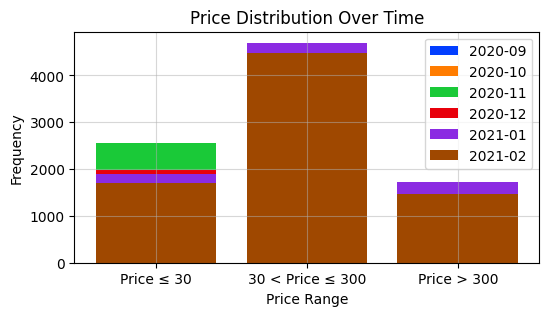

In [90]:
plt.figure(figsize=(6, 3))
sns.set_palette("bright", len(res_df))
# Plot each hour's distribution
for _, row in res_df.iterrows():
    # Get the counts for each category
    categories = [
        f"Price ≤ {lower_price}",
        f"{lower_price} < Price ≤ {upper_price}",
        f"Price > {upper_price}",
    ]
    counts = [row["distribution"][i] for i in range(len(categories))]
    # Plot bars for this hour
    bars = plt.bar(
        categories,
        counts,
        label=f'{row["bucket"].year}-{row["bucket"].month:02}',
    )
# Customize plot
plt.title("Price Distribution Over Time")
plt.xlabel("Price Range")
plt.ylabel("Frequency")
plt.legend()
plt.grid(visible=True, alpha=0.5)
# Show plot
plt.show()

In [91]:
query = """
    SELECT * FROM timescaledb_information.jobs
    WHERE proc_name = 'policy_reorder';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[]


In [92]:
query = """
    SELECT add_reorder_policy(
        't_user_events',
        index_name => 'ix_events_time_user_id');"""
res = execute_trans_query(query, fetch_size=0)

In [93]:
query = """
    SELECT *
    FROM timescaledb_information.jobs
    WHERE proc_name = 'policy_reorder';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'job_id': 1_001,
  'application_name': 'Reorder Policy [1001]',
  'schedule_interval': datetime.timedelta(seconds=1800),
  'max_runtime': datetime.timedelta(0),
  'max_retries': -1,
  'retry_period': datetime.timedelta(seconds=300),
  'proc_schema': '_timescaledb_functions',
  'proc_name': 'policy_reorder',
  'owner': 'timescaledb',
  'scheduled': True,
  'fixed_schedule': False,
  'config': {'index_name': 'ix_events_time_user_id', 'hypertable_id': 1},
  'next_start': None,
  'initial_start': None,
  'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'check_schema': '_timescaledb_functions',
  'check_name': 'policy_reorder_check'}]


In [94]:
query = """
    SELECT approximate_row_count('t_user_events');"""
start = default_timer()
res = execute_trans_query(query, fetch_size=3)
end = default_timer()
print(f"'approximate_row_count' exec time: {end - start:.4f} seconds")
pprint(res)

'approximate_row_count' exec time: 0.0194 seconds
[{'approximate_row_count': 885_132}]


In [95]:
query = """
    SELECT count(*)
    FROM t_user_events;"""
start = default_timer()
res = execute_trans_query(query, fetch_size=3)
end = default_timer()
print(f"'count' exec time: {end - start:.4f} seconds")
pprint(res)

'count' exec time: 0.7853 seconds
[{'count': 885_135}]


In [96]:
query = """
    DROP TABLE IF EXISTS db_event_logs;
    CREATE TABLE db_event_logs (
        log_id SERIAL PRIMARY KEY,
        operation VARCHAR(10) NOT NULL,
        tablename TEXT,
        changed_at TIMESTAMP DEFAULT NOW(),
        changed_by TEXT,
        old_data JSONB,
        new_data JSONB
    );"""
res = execute_trans_query(query, fetch_size=0)

In [97]:
query = """
    DROP  FUNCTION IF EXISTS log_db_iud CASCADE;
    CREATE OR REPLACE FUNCTION log_db_iud()
    RETURNS TRIGGER AS $$
    BEGIN
        IF TG_OP = 'INSERT' THEN
            INSERT INTO db_event_logs (
                operation, tablename, new_data,
                changed_by)
            VALUES (
                TG_OP, TG_TABLE_NAME, row_to_json(NEW),
                current_user);
        ELSIF TG_OP = 'UPDATE' THEN
            INSERT INTO db_event_logs (
                operation, tablename, old_data,
                new_data, changed_by)
            VALUES (
                TG_OP, TG_TABLE_NAME, row_to_json(OLD),
                row_to_json(NEW), current_user);
        ELSIF TG_OP = 'DELETE' THEN
            INSERT INTO db_event_logs (
                operation, tablename, old_data,
                changed_by)
            VALUES (
                TG_OP, TG_TABLE_NAME, row_to_json(OLD),
                current_user);
        END IF;
        RETURN NEW;
    END;
    $$ LANGUAGE plpgsql;"""
res = execute_trans_query(query, fetch_size=0)

In [98]:
query = """
    DROP TRIGGER IF EXISTS log_db_iud ON t_user_events;
    CREATE TRIGGER log_db_iud
    AFTER INSERT OR UPDATE OR DELETE ON t_user_events
    FOR EACH ROW
    EXECUTE FUNCTION log_db_iud();"""
res = execute_trans_query(query, fetch_size=0)

In [99]:
query = """
    INSERT INTO t_user_events (
        event_time, event_type, product_id,
        category_id, category_code, brand,
        price, user_id, user_session)
    VALUES
        ('2050-02-01 12:34:56', 'purchase', 123,
            456, 'electronics.smartphone', 'BrandX',
            599.99, 789, 'a0eebc99-9c0b-4ef8-bb6d-6bb9bd380a11');"""
res = execute_trans_query(query, fetch_size=0)

In [100]:
query = """
    UPDATE t_user_events
    SET brand = 'Waldo'
    WHERE event_time >= '2050-02-01';"""
res = execute_trans_query(query, fetch_size=0)

In [101]:
query = """
    DELETE FROM t_user_events
    WHERE event_time >= '2050-02-01';"""
res = execute_trans_query(query, fetch_size=0)

In [102]:
query = """
    SELECT *
    FROM db_event_logs"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'log_id': 1,
  'operation': 'INSERT',
  'tablename': '_hyper_1_3969_chunk',
  'changed_at': datetime.datetime(2025, 2, 2, 16, 17, 16, 159895),
  'changed_by': 'timescaledb',
  'old_data': None,
  'new_data': {'brand': 'BrandX',
               'price': 599.99,
               'user_id': 789,
               'event_time': '2050-02-01T12:34:56+00:00',
               'event_type': 'purchase',
               'product_id': 123,
               'category_id': 456,
               'user_session': 'a0eebc99-9c0b-4ef8-bb6d-6bb9bd380a11',
               'category_code': 'electronics.smartphone'}},
 {'log_id': 2,
  'operation': 'UPDATE',
  'tablename': '_hyper_1_3969_chunk',
  'changed_at': datetime.datetime(2025, 2, 2, 16, 17, 16, 193787),
  'changed_by': 'timescaledb',
  'old_data': {'brand': 'BrandX',
               'price': 599.99,
               'user_id': 789,
               'event_time': '2050-02-01T12:34:56+00:00',
               'event_type': 'purchase',
               'product_id': 123,
  

In [103]:
query = """
    SELECT
        percentile_disc(0.5) WITHIN GROUP (ORDER BY price) as median,
        percentile_disc(0.25) WITHIN GROUP (ORDER BY price) as first_quartile,
        percentile_disc(0.75) WITHIN GROUP (ORDER BY price) as third_quartile,
        percentile_disc(0.90) WITHIN GROUP (ORDER BY price) as nineteenth_percentile
    FROM t_user_events
    WHERE event_time >= '2020-01-01'
        AND event_time < '2024-01-01'
        AND event_type = 'purchase';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'median': Decimal('64.48'),
  'first_quartile': Decimal('26.22'),
  'third_quartile': Decimal('202.67'),
  'nineteenth_percentile': Decimal('397.48')}]


In [104]:
query = """
    SELECT
        percentile_cont(0.5) WITHIN GROUP (ORDER BY price) as median,
        percentile_cont(0.25) WITHIN GROUP (ORDER BY price) as first_quartile,
        percentile_cont(0.75) WITHIN GROUP (ORDER BY price) as third_quartile,
        percentile_cont(0.90) WITHIN GROUP (ORDER BY price) as nineteenth_percentile
    FROM t_user_events
    WHERE event_time >= '2020-01-01'
        AND event_time < '2024-01-01'
        AND event_type = 'purchase';"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'median': 64.48,
  'first_quartile': 26.22,
  'third_quartile': 202.67,
  'nineteenth_percentile': 397.48}]


In [105]:
query = """
    SELECT
        time_bucket('1 day', event_time) as bucket,
        time_weight('Linear', event_time, price) AS tws_price
    FROM t_user_events
    WHERE event_time >= '2020-01-01'
        AND event_time < '2024-01-01'
        AND event_type = 'view'
    GROUP BY bucket;"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'bucket': datetime.datetime(2020, 9, 24, 0, 0, tzinfo=datetime.timezone.utc),
  'tws_price': '(version:1,first:(ts:"2020-09-24 '
               '11:57:06+00",val:31.9),last:(ts:"2020-09-24 '
               '23:56:10+00",val:38.83),weighted_sum:4718336105000,method:Linear)'},
 {'bucket': datetime.datetime(2020, 9, 25, 0, 0, tzinfo=datetime.timezone.utc),
  'tws_price': '(version:1,first:(ts:"2020-09-25 '
               '00:00:01+00",val:9.37),last:(ts:"2020-09-25 '
               '23:58:25+00",val:167.62),weighted_sum:10649115350000,method:Linear)'},
 {'bucket': datetime.datetime(2020, 9, 26, 0, 0, tzinfo=datetime.timezone.utc),
  'tws_price': '(version:1,first:(ts:"2020-09-26 '
               '00:00:26+00",val:339.16),last:(ts:"2020-09-26 '
               '23:59:54+00",val:31.76),weighted_sum:9858671245000,method:Linear)'},
 {'bucket': datetime.datetime(2020, 9, 27, 0, 0, tzinfo=datetime.timezone.utc),
  'tws_price': '(version:1,first:(ts:"2020-09-27 '
               '00:13:25+00",va

In [106]:
query = """
    SELECT
        bucket,
        average(tws_price)
    FROM (
        SELECT
            time_bucket('1 day', event_time) as bucket,
            time_weight('Linear', event_time, price) AS tws_price
        FROM t_user_events
        WHERE event_time >= '2020-01-01'
            AND event_time < '2024-01-01'
            AND event_type = 'view'
        GROUP BY bucket
    ) t;"""
res = execute_trans_query(query, fetch_size=5)
pprint(res)

[{'bucket': datetime.datetime(2020, 9, 24, 0, 0, tzinfo=datetime.timezone.utc),
  'average': 109.36250938716856},
 {'bucket': datetime.datetime(2020, 9, 25, 0, 0, tzinfo=datetime.timezone.utc),
  'average': 123.3907507183908},
 {'bucket': datetime.datetime(2020, 9, 26, 0, 0, tzinfo=datetime.timezone.utc),
  'average': 114.1472680275102},
 {'bucket': datetime.datetime(2020, 9, 27, 0, 0, tzinfo=datetime.timezone.utc),
  'average': 134.68269605264695},
 {'bucket': datetime.datetime(2020, 9, 28, 0, 0, tzinfo=datetime.timezone.utc),
  'average': 112.32651800919865}]


In [107]:
query = """
    SELECT *
    FROM unnest((
        SELECT asap_smooth(event_time, price, 8)
        FROM t_user_events));"""
res = execute_trans_query(query, fetch_size=10)
pprint(res)

[{'time': datetime.datetime(2018, 2, 1, 12, 34, 56, tzinfo=datetime.timezone.utc),
  'value': 114.49768331812362},
 {'time': datetime.datetime(2018, 12, 11, 12, 55, 8, 428571, tzinfo=datetime.timezone.utc),
  'value': 115.78822172613101},
 {'time': datetime.datetime(2019, 10, 20, 13, 15, 20, 857142, tzinfo=datetime.timezone.utc),
  'value': 123.0237977784098},
 {'time': datetime.datetime(2020, 8, 28, 13, 35, 33, 285713, tzinfo=datetime.timezone.utc),
  'value': 130.08937925363486},
 {'time': datetime.datetime(2021, 7, 7, 13, 55, 45, 714284, tzinfo=datetime.timezone.utc),
  'value': 147.00277049196578},
 {'time': datetime.datetime(2022, 5, 16, 14, 15, 58, 142855, tzinfo=datetime.timezone.utc),
  'value': 186.86023969416328},
 {'time': datetime.datetime(2023, 3, 25, 14, 36, 10, 571426, tzinfo=datetime.timezone.utc),
  'value': 174.87272728917455},
 {'time': datetime.datetime(2024, 2, 1, 14, 56, 22, 999997, tzinfo=datetime.timezone.utc),
  'value': 178.511393244822}]


## DB-Breaking Statements

### Setup

In [108]:
query = """
    CREATE TABLE t_user_events_month_chunk (
        event_time TIMESTAMPTZ,
        event_type VARCHAR(100),
        product_id INT,
        category_id BIGINT,
        category_code VARCHAR(100),
        brand VARCHAR(100),
        price NUMERIC,
        user_id BIGINT,
        user_session VARCHAR(100)
    );"""
res = execute_trans_query(query, fetch_size=0)

In [109]:
print_chunk_info(table_name="t_user_events_month_chunk")

Current chunks info:
[]


In [110]:
query = """
    SELECT create_hypertable(
                't_user_events_month_chunk',
                'event_time',
                chunk_time_interval => INTERVAL '1 month'
    );"""
res = execute_trans_query(query, fetch_size=0)

In [111]:
query = """
    INSERT INTO t_user_events_month_chunk
    SELECT * FROM t_user_events;"""
res = execute_trans_query(query, fetch_size=0)

In [112]:
query = """
    SELECT drop_chunks(
            't_user_events_month_chunk',
            older_than => INTERVAL '6 months');"""
res = execute_trans_query(query, fetch_size=0)

In [113]:
sleep(60)
print_count(table_name="t_user_events_month_chunk")

Count: 0


In [114]:
print_chunk_info(table_name="t_user_events_month_chunk")

Current chunks info:
[]


In [115]:
print_compression_settings()

Compression settings:
[]


In [116]:
query = """
    ALTER TABLE t_user_events SET (
        timescaledb.compress,
        timescaledb.compress_orderby = 'event_time DESC',
        timescaledb.compress_segmentby = 'user_id, product_id');"""
res = execute_trans_query(query, fetch_size=0)

In [117]:
query = """
    SELECT add_compression_policy(
        't_user_events',
        INTERVAL '30 days');"""
res = execute_trans_query(query, fetch_size=0)

In [118]:
print_compression_settings()

Compression settings:
[{'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'attname': 'user_id',
  'segmentby_column_index': 1,
  'orderby_column_index': None,
  'orderby_asc': None,
  'orderby_nullsfirst': None},
 {'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'attname': 'product_id',
  'segmentby_column_index': 2,
  'orderby_column_index': None,
  'orderby_asc': None,
  'orderby_nullsfirst': None},
 {'hypertable_schema': 'public',
  'hypertable_name': 't_user_events',
  'attname': 'event_time',
  'segmentby_column_index': None,
  'orderby_column_index': 1,
  'orderby_asc': False,
  'orderby_nullsfirst': True}]


In [119]:
sleep(60)
print_chunk_info(fetch_size=3)

Current chunks info:
[{'chunk_name': '_hyper_1_1_chunk',
  'is_compressed': True,
  'range_start': datetime.datetime(2020, 9, 24, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 9, 25, 0, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_2_chunk',
  'is_compressed': True,
  'range_start': datetime.datetime(2020, 9, 29, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 9, 30, 0, 0, tzinfo=datetime.timezone.utc)},
 {'chunk_name': '_hyper_1_3_chunk',
  'is_compressed': True,
  'range_start': datetime.datetime(2020, 10, 2, 0, 0, tzinfo=datetime.timezone.utc),
  'range_end': datetime.datetime(2020, 10, 3, 0, 0, tzinfo=datetime.timezone.utc)}]


In [120]:
print_count()

Count: 885_135


In [121]:
query = """
    SELECT add_retention_policy(
                't_user_events',
                INTERVAL '100 years',
                if_not_exists => TRUE);"""
res = execute_trans_query(query, fetch_size=0)

In [122]:
print_count()

Count: 885_135


In [123]:
query = """
    SELECT remove_retention_policy('t_user_events');"""
res = execute_trans_query(query, fetch_size=0)

In [124]:
query = """
    SELECT add_retention_policy(
                't_user_events',
                INTERVAL '1 hour',
                if_not_exists => TRUE);"""
res = execute_trans_query(query, fetch_size=0)

In [125]:
sleep(60)
print_count()

Count: 885_135
